# Warming Stripes

In [0]:
# Dependencies
import requests
import datetime
import pandas as pd
from IPython import display # For updating the cell dynamically
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap

In [0]:
"""
Adapted from from Stefanie Molin: Hands-On-Data-Analysis-With-Pandas. Available at:
https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/tree/master/ch_04
"""

def make_request(endpoint, payload=None):
    """
    Make a request to a specific endpoint on the weather API
    passing headers and optional payload.
    
    Parameters:
        - endpoint: The endpoint of the API you want to 
                    make a GET request to.
        - payload: A dictionary of data to pass along 
                   with the request.
    
    Returns:
        Response object.
    """
    return requests.get(
        f'https://www.ncdc.noaa.gov/cdo-web/api/v2/{endpoint}',
        headers={
            'token': 'DOENrJHGTEFUiebNMWZLniFJXUGTiVxr'
        },
        params=payload
    )

In [0]:
def GetData(stationid, startYear, endYear, sampleFreq):
    """
    This function grabs min and max daily temperature data for a chosen station from NOAA GHCND climate dataset.
    It then calculates the average temperature over a chosen date range.
    
    Parameters:
        - stationid:  A string of the GHCND station identifier
                      Example : GHCND:UK000000000
        - startYear:  Integer of first year of date range
        - endYear:    Integer of last year of date range
        - sampleFreq: String of pandas DateOffset alias (e.g. "12M" for 12 month resampling)
                      For documentation, see https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
    
    Returns:
        Pandas dataframe of mean temperatures (TAvg)
    """

    start = startYear
    end = endYear

    results = []

    while start <= end:
        
        currentStart = datetime.date(start, 1, 1)
        currentEnd = datetime.date(start + 1, 1, 1)
        
        # Update the cell with status information
        display.clear_output(wait=True)
        display.display(f'Gathering data for {str(currentStart)}')
        
        response = make_request('data', 
            {
                'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
                'stationid' : stationid, # Station ID
                'startdate' : currentStart,
                'enddate' : currentEnd,
                'units' : 'metric', # Temperature units are degrees C
                'limit' : 1000 # Return maximum allowed
            })

        if response.ok:
            # We extend the list instead of appending to avoid getting a nested list
            results.extend(response.json()['results'])

        # Update the current date to avoid an infinite loop
        start += 1
        
    # Convert to Pandas Dataframe and tidy
    df = pd.DataFrame(results)
    del df["attributes"] # Needles
    df["date"] = df["date"].str[:10] # Get ride of time stamp
    df["date"] = df.apply(lambda x: datetime.datetime.strptime(x["date"], "%Y-%m-%d"), axis = 1) # Convert dates to datetime format
    df = df.groupby("date").mean() # Take mean of Tmax and Tmin
    df.rename(columns = {"value" : "TAvg"}, inplace = True)
           
    # Re-sample at chosen frequency and return dataframe
    return df.resample(sampleFreq).mean()

## Example

In [0]:
# Define parameters
startYear = 1950
endYear = 2010
stationid = "GHCND:UK000003026" # Stornoway, UK
sampleFreq = "AS" # Yearly

In [11]:
# Get dataframe
df = GetData(stationid, startYear, endYear, sampleFreq)

'Gathering data for 2010-01-01'

In [63]:
print(type(startYear))


<class 'int'>


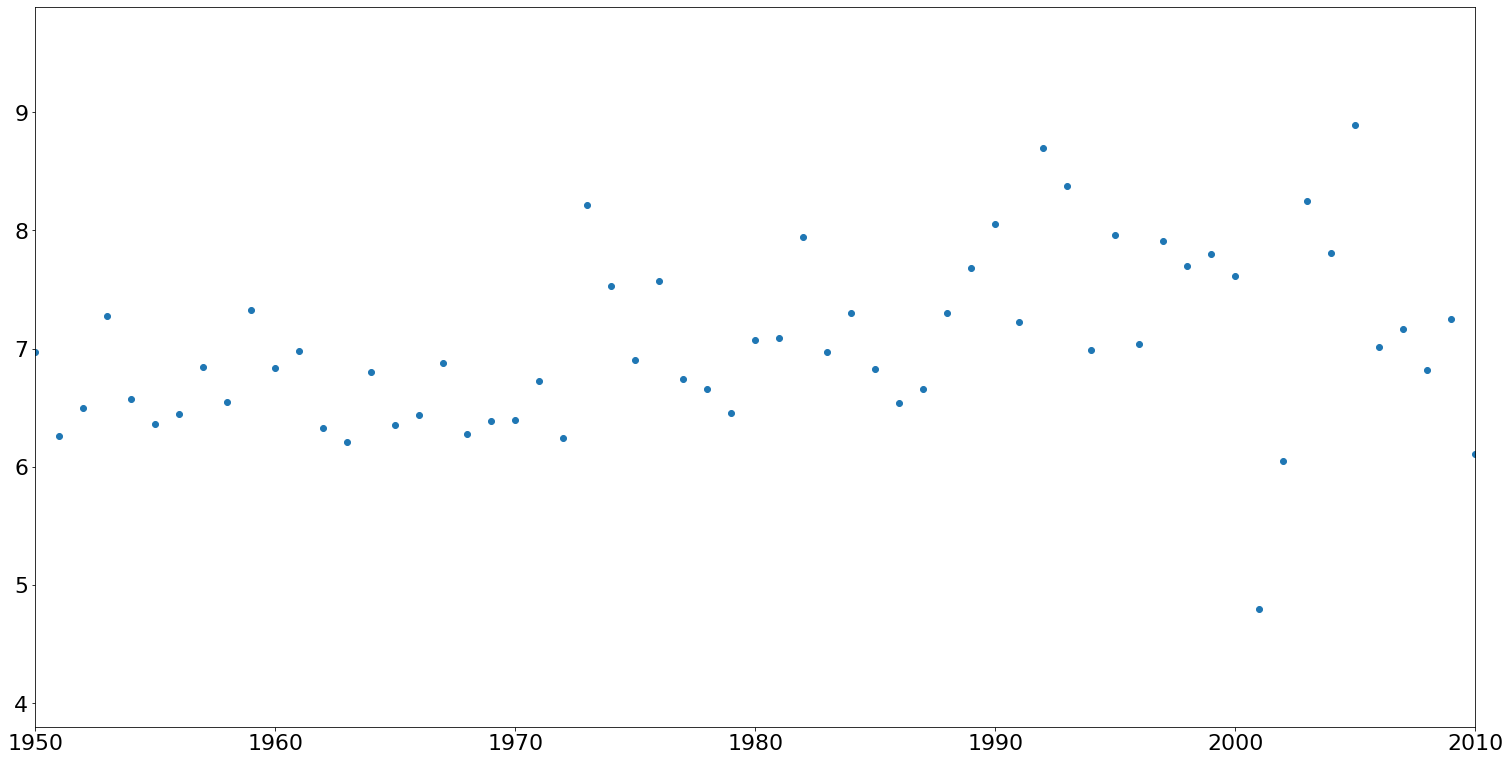

In [93]:
# Warming stripes (adapted from https://matplotlib.org/matplotblog/posts/warming-stripes/)
startYear_datetime = datetime.datetime(startYear, 1, 1)
endYear_datetime = datetime.datetime(endYear, 1, 1)

reference = df["TAvg"].mean()
lim = 2.0
y_max = df["TAvg"].max()+1
y_min = df["TAvg"].min()-1
height = df["TAvg"].min()-1, df["TAvg"].max()+1
cmap = ListedColormap([
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
])

fig = plt.figure(figsize=(20, 10))

ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlim(startYear_datetime, endYear_datetime)
ax.set_ylim(y_min, y_max)
ax.set_axis_on()

# create a collection with a rectangle for each year
col = PatchCollection([
    Rectangle((y, 0), 1, y_max-y_min)
    for y in range(startYear, endYear + 1)
])


# set data, colormap and color limits
col.set_array(df["TAvg"])
col.set_cmap(cmap)
col.set_clim(reference - lim, reference + lim)
ax.add_collection(col).set_zorder(0)

ax.scatter(df.index, df["TAvg"], zorder=1)

#ax.set_xbound(startYear_datetime, endYear_datetime)
#ax.set_ybound(df["TAvg"].min()-1, df["TAvg"].max()+1)

plt.show()

### Old code (that may be useful)

In [0]:
"""
Search for UK stations in the GHNCD dataset and show the results (json)
"""

station_id = make_request('stations', 
        {
            'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
            'locationid' : 'FIPS:UK', # IL
            'datacategoryid' : 'TEMP', # Check for temperature data
            'limit' : 1000 # Return maximum allowed
        }).json()["results"]

In [0]:
station_id

[{'elevation': 78,
  'mindate': '1880-12-31',
  'maxdate': '2017-12-31',
  'latitude': 52.42,
  'name': 'CET CENTRAL ENGLAND, UK',
  'datacoverage': 1,
  'id': 'GHCND:UK000000000',
  'elevationUnit': 'METERS',
  'longitude': -1.83},
 {'elevation': 82,
  'mindate': '1929-10-01',
  'maxdate': '2020-02-04',
  'latitude': 60.1331,
  'name': 'LERWICK, UK',
  'datacoverage': 0.9895,
  'id': 'GHCND:UK000003005',
  'elevationUnit': 'METERS',
  'longitude': -1.1831},
 {'elevation': 9,
  'mindate': '1873-07-01',
  'maxdate': '2020-02-04',
  'latitude': 58.33,
  'name': 'STORNOWAY AIRPORT, UK',
  'datacoverage': 0.9876,
  'id': 'GHCND:UK000003026',
  'elevationUnit': 'METERS',
  'longitude': -6.32},
 {'elevation': 242,
  'mindate': '1931-01-01',
  'maxdate': '2020-02-04',
  'latitude': 55.3167,
  'name': 'ESKDALEMUIR, UK',
  'datacoverage': 0.9991,
  'id': 'GHCND:UK000003162',
  'elevationUnit': 'METERS',
  'longitude': -3.2},
 {'elevation': 11,
  'mindate': '1930-12-01',
  'maxdate': '2020-02-04

In [0]:
df = pd.DataFrame(station_id)
df["mindate"] = df["mindate"].str[:10] # Get ride of time stamp
df["mindate"] = df.apply(lambda x: datetime.strptime(x["mindate"], "%Y-%m-%d"), axis = 1)

df["maxdate"] = df["maxdate"].str[:10] # Get ride of time stamp
df["maxdate"] = df.apply(lambda x: datetime.strptime(x["maxdate"], "%Y-%m-%d"), axis = 1)

In [0]:
from datetime import datetime
df_subset = df[df.mindate < datetime(1900, 1, 1)]

In [0]:
df_subset[df_subset.id == df_subset.id.values[0]].name.values

In [0]:
ds = df.to_xarray()

In [0]:
ds2 = ds.assign_coords(lon = ds.longitude.values, lat = ds.latitude.values)

In [0]:
""" 
Choose "CET CENTRAL ENGLAND, UK" (first station): good data coverage and records begin in 1880. 
Check what temperature observations are available.
"""

make_request('datatypes', 
        {
            'datasetid' : 'GHCND',
            'stationid' : 'GHCND:USC00111992', # Station ID
            'datacategoryid' : 'TEMP' # Show temperature variables
        }).json()

In [0]:
""" 
Now let's pull the relevant data. We want TMAX and TMIN to calculate the mean. 
The API only allows one year of daily data to be grabbed at one go.
""" 

start = datetime.date(1881, 1, 1)
end = datetime.date(1882, 1, 1)

station_dict = make_request('data', 
        {
            'datasetid' : 'GHCND',
            'stationid' : 'GHCND:UK000000000',
            'startdate' : start,
            'enddate' : end,
            'units' : 'metric', # Temperature units are degrees C
            'limit' : 1000 
        }).json()["results"]

In [0]:
make_request('data', 
            {
                'datasetid' : 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
                'datatypeid' : 'TMAX;TMIN',
                'stationid' : "GHCND:UK000000000", # Station ID
                'startdate' : datetime.date(2000, 1, 1),
                'enddate' : datetime.date(2001, 1, 1),
                'units' : 'metric', # Temperature units are degrees C
                'limit' : 1000 # Return maximum allowed
            }).json()

In [0]:
def plot(df):
    reference = df["TAvg"].mean()
    